<a href="https://colab.research.google.com/github/anjali-ojha/deep-learning/blob/a9/assignment/assignment-9/Anjali_Ojha_HW_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GitHub Link - https://github.com/anjali-ojha/deep-learning/blob/a9/assignment/assignment-9/Anjali_Ojha_HW_9.ipynb

## Follow the official Pytorch demo tutorial for Transformer Translation: Transformer model for language understanding (https://www.tensorflow.org/text/tutorials/transformer)

# Step1. Run the demo and train a model on the original German-to-English training set.

In [ ]:
%matplotlib inline

In [ ]:
!pip install torchtext
!pip install -U torchdata
!pip install portalocker
!pip install spacy
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List

In [ ]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

In [ ]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


def prepare_data(SRC_LANGUAGE, TGT_LANGUAGE):

    token_transform = {}
    vocab_transform = {}

    token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language= 'de_core_news_sm' if SRC_LANGUAGE == 'de' else 'en_core_web_sm')
    token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language= 'en_core_web_sm' if TGT_LANGUAGE == 'en' else 'de_core_news_sm')


    # helper function to yield list of tokens
    def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
        language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

        for data_sample in data_iter:
            yield token_transform[language](data_sample[language_index[language]])

    # # Define special symbols and indices
    # UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
    # # Make sure the tokens are in order of their indices to properly insert them in vocab
    # special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

    """
    Purpose: Defines special tokens used in the vocabulary for machine learning tasks with text data.
    Special Tokens:
    <unk>: "Unknown" token (represents words not in the vocabulary)
    <pad>: Padding token (to make sequences the same length)
    <bos>: "Beginning of Sequence"
    <eos>: "End of Sequence"
    """

    for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
        # Training data Iterator
        train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
        # Create torchtext's Vocab object
        vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                        min_freq=1,
                                                        specials=special_symbols,
                                                        special_first=True)

    # Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
    # If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
    for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
        vocab_transform[ln].set_default_index(UNK_IDX)

    # helper function to club together sequential operations
    def sequential_transforms(*transforms):
        def func(txt_input):
            for transform in transforms:
                txt_input = transform(txt_input)
            return txt_input
        return func

    # function to add BOS/EOS and create tensor for input sequence indices
    def tensor_transform(token_ids: List[int]):
        return torch.cat((torch.tensor([BOS_IDX]),
                          torch.tensor(token_ids),
                          torch.tensor([EOS_IDX])))

    # ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
    text_transform = {}
    for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
        text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                                   vocab_transform[ln], #Numericalization
                                                   tensor_transform) # Add BOS/EOS and create tensor

    return token_transform, vocab_transform, text_transform




In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_built() else 'cpu'))

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
from torch.nn.utils.rnn import pad_sequence


def create_data_loader(iter_data, BATCH_SIZE, SRC_LANGUAGE, TGT_LANGUAGE, text_transform):
    def collate_fn(batch):
        src_batch, tgt_batch = [], []
        for src_sample, tgt_sample in batch:
            src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
            tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

        src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
        tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
        return src_batch, tgt_batch

    return DataLoader(iter_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)


def train_epoch(model, optimizer, BATCH_SIZE, SRC_LANGUAGE, TGT_LANGUAGE, text_transform):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    train_dataloader = create_data_loader(train_iter, BATCH_SIZE, SRC_LANGUAGE, TGT_LANGUAGE, text_transform)

    for src, tgt in tqdm(train_dataloader, desc="Processing items"): #train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))



def evaluate(model, BATCH_SIZE, SRC_LANGUAGE, TGT_LANGUAGE, text_transform):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    val_dataloader = create_data_loader(val_iter, BATCH_SIZE, SRC_LANGUAGE, TGT_LANGUAGE, text_transform)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str, SRC_LANGUAGE: str, TGT_LANGUAGE: str, text_transform, vocab_transform):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
SRC_LANGUAGE_de_to_en = 'de'
TGT_LANGUAGE_de_to_en = 'en'

token_transform_de_to_en, vocab_transform_de_to_en, text_transform_de_to_en = prepare_data(SRC_LANGUAGE_de_to_en, TGT_LANGUAGE_de_to_en)

torch.manual_seed(0)

SRC_VOCAB_SIZE_de_to_en = len(vocab_transform_de_to_en[SRC_LANGUAGE_de_to_en])
TGT_VOCAB_SIZE_de_to_en = len(vocab_transform_de_to_en[TGT_LANGUAGE_de_to_en])

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer_de_to_en = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                          NHEAD, SRC_VOCAB_SIZE_de_to_en, TGT_VOCAB_SIZE_de_to_en,
                                          FFN_HID_DIM)

for p in transformer_de_to_en.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer_de_to_en = transformer_de_to_en.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer_de_to_en = torch.optim.Adam(transformer_de_to_en.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


from timeit import default_timer as timer
NUM_EPOCHS = 20

training_losses_de_to_en, val_losses_de_to_en = [], []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer_de_to_en, optimizer_de_to_en, BATCH_SIZE,
                             SRC_LANGUAGE_de_to_en, TGT_LANGUAGE_de_to_en, text_transform_de_to_en)
    end_time = timer()
    val_loss = evaluate(transformer_de_to_en,  BATCH_SIZE, SRC_LANGUAGE_de_to_en, TGT_LANGUAGE_de_to_en, text_transform_de_to_en)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    training_losses_de_to_en.append(train_loss)
    val_losses_de_to_en.append(val_loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Processing items: 0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Processing items: 227it [00:42,  5.33it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We 

Epoch: 1, Train loss: 5.344, Val loss: 4.106, Epoch time = 47.538s


Processing items: 227it [00:40,  5.66it/s]


Epoch: 2, Train loss: 3.761, Val loss: 3.309, Epoch time = 45.434s


Processing items: 227it [00:40,  5.62it/s]


Epoch: 3, Train loss: 3.157, Val loss: 2.887, Epoch time = 45.325s


Processing items: 227it [00:40,  5.64it/s]


Epoch: 4, Train loss: 2.767, Val loss: 2.640, Epoch time = 44.587s


Processing items: 227it [00:40,  5.62it/s]


Epoch: 5, Train loss: 2.477, Val loss: 2.442, Epoch time = 44.720s


Processing items: 227it [00:40,  5.63it/s]


Epoch: 6, Train loss: 2.247, Val loss: 2.306, Epoch time = 45.571s


Processing items: 227it [00:40,  5.63it/s]


Epoch: 7, Train loss: 2.055, Val loss: 2.207, Epoch time = 45.748s


Processing items: 227it [00:40,  5.63it/s]


Epoch: 8, Train loss: 1.893, Val loss: 2.114, Epoch time = 44.818s


Processing items: 227it [00:40,  5.62it/s]


Epoch: 9, Train loss: 1.754, Val loss: 2.054, Epoch time = 44.723s


Processing items: 227it [00:40,  5.63it/s]


Epoch: 10, Train loss: 1.628, Val loss: 2.008, Epoch time = 45.137s


Processing items: 227it [00:40,  5.67it/s]


Epoch: 11, Train loss: 1.520, Val loss: 1.961, Epoch time = 45.047s


Processing items: 227it [00:40,  5.65it/s]


Epoch: 12, Train loss: 1.420, Val loss: 1.958, Epoch time = 44.480s


Processing items: 227it [00:40,  5.67it/s]


Epoch: 13, Train loss: 1.330, Val loss: 1.972, Epoch time = 44.318s


Processing items: 227it [00:39,  5.68it/s]


Epoch: 14, Train loss: 1.245, Val loss: 1.978, Epoch time = 44.523s


Processing items: 227it [00:39,  5.70it/s]


Epoch: 15, Train loss: 1.173, Val loss: 1.929, Epoch time = 44.847s


Processing items: 227it [00:39,  5.68it/s]


Epoch: 16, Train loss: 1.103, Val loss: 1.901, Epoch time = 44.267s


Processing items: 227it [00:39,  5.69it/s]


Epoch: 17, Train loss: 1.035, Val loss: 1.912, Epoch time = 44.152s


Processing items: 227it [00:40,  5.56it/s]


Epoch: 18, Train loss: 0.973, Val loss: 1.927, Epoch time = 45.146s


Processing items: 227it [00:40,  5.63it/s]


Epoch: 19, Train loss: 0.918, Val loss: 1.947, Epoch time = 45.309s


Processing items: 227it [00:39,  5.70it/s]


Epoch: 20, Train loss: 0.866, Val loss: 1.942, Epoch time = 44.903s


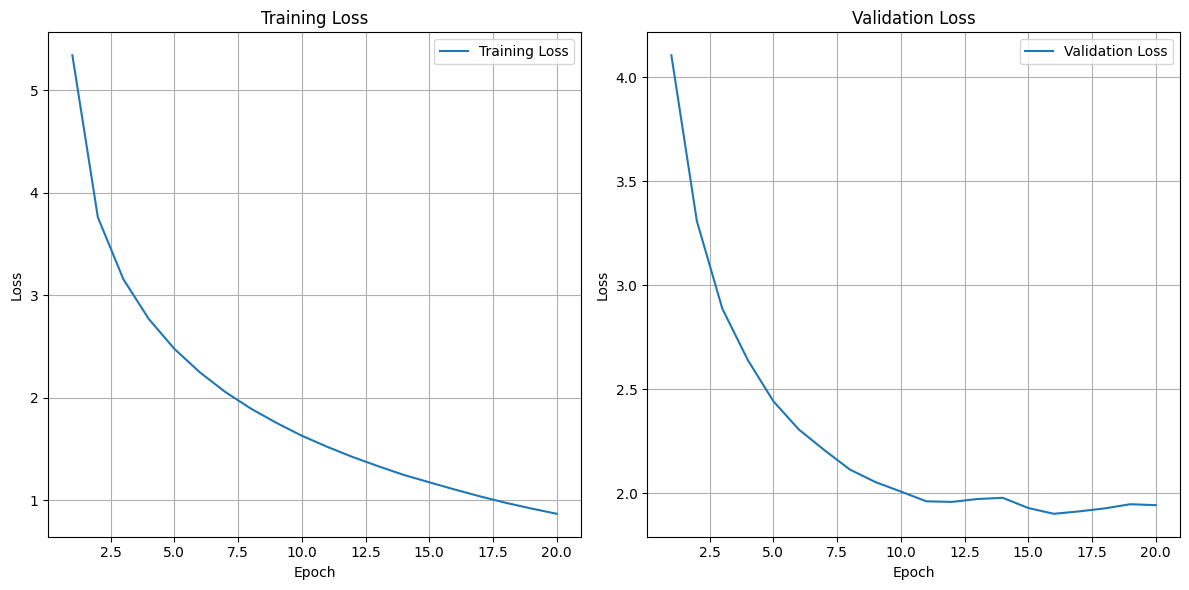

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_training_stats(train_losses, val_losses):
    epochs = np.arange(1, len(train_losses) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot training losses
    axs[0].plot(epochs, train_losses, label='Training Loss')
    axs[0].set_title('Training Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # Plot validation losses
    axs[1].plot(epochs, val_losses, label='Validation Loss')
    axs[1].set_title('Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_training_stats(training_losses_de_to_en, val_losses_de_to_en)


In [ ]:
def to_english(sentence):
    return translate(transformer_de_to_en,
                sentence,
                SRC_LANGUAGE_de_to_en, TGT_LANGUAGE_de_to_en,
                text_transform_de_to_en, vocab_transform_de_to_en)


# print(to_english("Eine Gruppe von Personen steht vor einer Menschenmenge ."))
print(to_english("Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people standing in front of an igloo 


# Step2. Train a New model of the same architecture on the opposite training set (English-to-German)

In [ ]:
SRC_LANGUAGE_en_to_de = 'en'
TGT_LANGUAGE_en_to_de = 'de'

token_transform_en_to_de, vocab_transform_en_to_de, text_transform_en_to_de = prepare_data(SRC_LANGUAGE_en_to_de, TGT_LANGUAGE_en_to_de)

torch.manual_seed(0)

SRC_VOCAB_SIZE_en_to_de = len(vocab_transform_en_to_de[SRC_LANGUAGE_en_to_de])
TGT_VOCAB_SIZE_en_to_de = len(vocab_transform_en_to_de[TGT_LANGUAGE_en_to_de])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer_en_to_de = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                          NHEAD, SRC_VOCAB_SIZE_en_to_de, TGT_VOCAB_SIZE_en_to_de,
                                          FFN_HID_DIM)

for p in transformer_en_to_de.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer_en_to_de = transformer_en_to_de.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer_en_to_de = torch.optim.Adam(transformer_en_to_de.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)


NUM_EPOCHS = 20

training_losses_en_to_de, val_losses_en_to_de = [], []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer_en_to_de, optimizer_en_to_de, BATCH_SIZE,
                             SRC_LANGUAGE_en_to_de, TGT_LANGUAGE_en_to_de, text_transform_en_to_de)
    end_time = timer()
    val_loss = evaluate(transformer_en_to_de,  BATCH_SIZE, SRC_LANGUAGE_en_to_de, TGT_LANGUAGE_en_to_de, text_transform_de_to_en)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

    training_losses_en_to_de.append(train_loss)
    val_losses_en_to_de.append(val_loss)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Processing items: 227it [00:46,  4.85it/s]


Epoch: 1, Train loss: 5.903, Val loss: 4.625, Epoch time = 51.467s


Processing items: 227it [00:46,  4.89it/s]


Epoch: 2, Train loss: 4.131, Val loss: 3.784, Epoch time = 51.299s


Processing items: 227it [00:46,  4.85it/s]


Epoch: 3, Train loss: 3.464, Val loss: 3.331, Epoch time = 50.975s


Processing items: 227it [00:47,  4.78it/s]


Epoch: 4, Train loss: 3.026, Val loss: 3.011, Epoch time = 54.016s


Processing items: 227it [00:47,  4.78it/s]


Epoch: 5, Train loss: 2.703, Val loss: 2.813, Epoch time = 51.735s


Processing items: 227it [00:46,  4.87it/s]


Epoch: 6, Train loss: 2.443, Val loss: 2.652, Epoch time = 50.872s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 7, Train loss: 2.229, Val loss: 2.503, Epoch time = 51.669s


Processing items: 227it [00:46,  4.85it/s]


Epoch: 8, Train loss: 2.059, Val loss: 2.385, Epoch time = 51.016s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 9, Train loss: 1.904, Val loss: 2.293, Epoch time = 50.900s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 10, Train loss: 1.767, Val loss: 2.225, Epoch time = 51.735s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 11, Train loss: 1.648, Val loss: 2.198, Epoch time = 50.900s


Processing items: 227it [00:46,  4.87it/s]


Epoch: 12, Train loss: 1.545, Val loss: 2.177, Epoch time = 50.885s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 13, Train loss: 1.452, Val loss: 2.178, Epoch time = 51.657s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 14, Train loss: 1.360, Val loss: 2.151, Epoch time = 50.907s


Processing items: 227it [00:46,  4.86it/s]


Epoch: 15, Train loss: 1.280, Val loss: 2.090, Epoch time = 50.953s


Processing items: 227it [00:46,  4.87it/s]


Epoch: 16, Train loss: 1.212, Val loss: 2.075, Epoch time = 51.653s


Processing items: 227it [00:46,  4.87it/s]


Epoch: 17, Train loss: 1.139, Val loss: 2.071, Epoch time = 51.126s


Processing items: 227it [00:46,  4.87it/s]


Epoch: 18, Train loss: 1.069, Val loss: 2.080, Epoch time = 50.829s


Processing items: 227it [00:46,  4.87it/s]


Epoch: 19, Train loss: 1.010, Val loss: 2.067, Epoch time = 51.247s


Processing items: 227it [00:46,  4.88it/s]


Epoch: 20, Train loss: 0.954, Val loss: 2.053, Epoch time = 51.250s


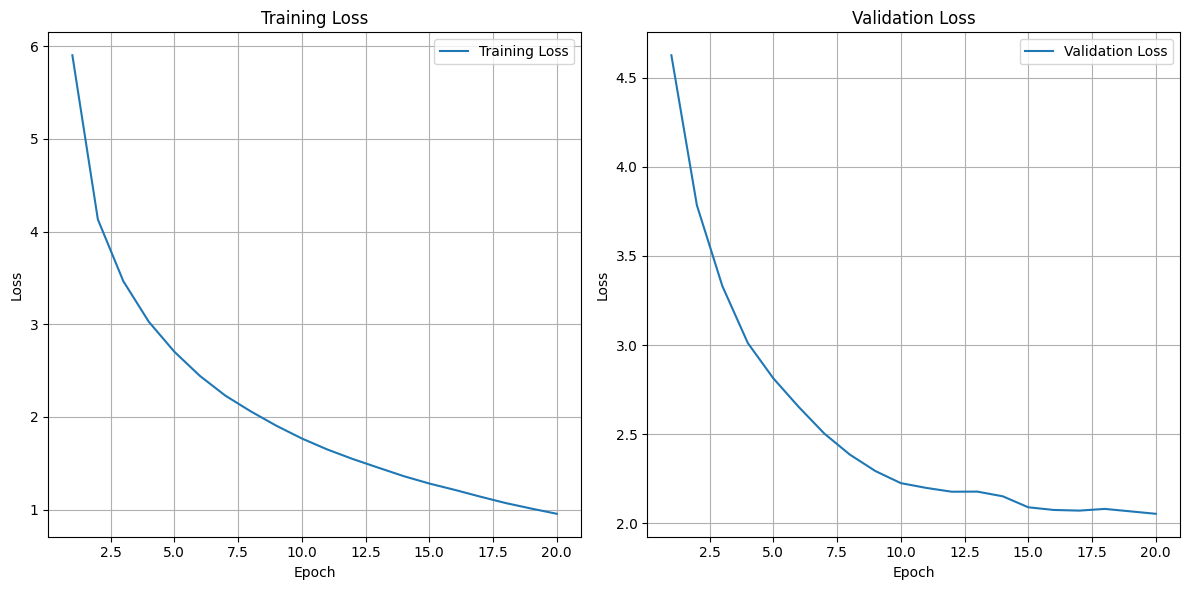

In [ ]:
plot_training_stats(training_losses_en_to_de, val_losses_en_to_de)

In [ ]:
def to_german(sentence):
    return translate(transformer_en_to_de,
                sentence,
                SRC_LANGUAGE_en_to_de, TGT_LANGUAGE_en_to_de,
                text_transform_en_to_de, vocab_transform_en_to_de)


# print(to_german("A group of people are standing in front of a crowd ."))
print(to_german("A group of people standing in front of an Igloo ."))

 Eine Gruppe von Personen steht vor einem Bekleidungsgeschäft . 


# Step3. Insert novel sentences into your English-to-German model. Take the output and feed it to the original German-to-English model. Observe and report qualitatively on the results

In [ ]:
sentences = ["A group of people standing in front of a crowd .",
             "This runner are competing to each other in the marathon .",
             "The tall boy with blue shirt is smiling ."]

for sentence in sentences:
    print(f"Orginal {sentence = }")
    german = to_german(sentence)
    english = to_english(german)

    print(f"\t Translated to  {german = } ")
    print(f"\t Translated to {english = } \n")

Orginal sentence = 'A group of people standing in front of a crowd .'
	 Translated to  german = ' Eine Gruppe von Personen steht vor einer Menschenmenge . ' 
	 Translated to english = ' A group of people stand in front of a crowd . ' 

Orginal sentence = 'This runner are competing to each other in the marathon .'
	 Translated to  german = ' Der Läufer kämpfen bei einem Marathon im Marathon miteinander . ' 
	 Translated to english = ' Runners runner fighting in a marathon during a marathon . ' 

Orginal sentence = 'The tall boy with blue shirt is smiling .'
	 Translated to  german = ' Ein großer Junge in einem blauen Oberteil lächelt . ' 
	 Translated to english = ' A large boy in a blue shirt smiles . ' 



#Observations -

* For simple sentence it works fine , but complex sentences its not working great.
* The continuous verb form is not translating well, it converts to simple present forms like standing becomes stands, smiling becomes smiles.
* Its not able to understand some words and uses the similar word like "fighting" for "competing".
* Corpus have some special characters like 'ß'.
* Overall it gets the sentence structures right but there are issues with morphology and verb forms.